In [1]:
#!pip install --user matplotlib==3.1.3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
#from xlrd import *
import string
import unidecode
import re
from itertools import compress
from datetime import datetime

In [2]:
#!pip install stargazer
from stargazer.stargazer import Stargazer

In [3]:
import spacy
nlp = spacy.load('es_core_news_sm')

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [4]:
import stanza

stanza.download('es')
stanza_tagger = stanza.Pipeline(lang='es', processors='tokenize,  pos, lemma')
parser = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

def pos_tagger(mytext):

  stanza_outcome = stanza_tagger(mytext)
  pos_text = [ word.text  for sent in stanza_outcome.sentences for word in sent.words]
  pos_upos = [ word.upos  for sent in stanza_outcome.sentences for word in sent.words]
  pos_xpos = [ word.xpos  for sent in stanza_outcome.sentences for word in sent.words]
  pos_lemma = [ word.lemma  for sent in stanza_outcome.sentences for word in sent.words]
  pos_feat = [ word.feats if word.feats else "_"  for sent in stanza_outcome.sentences for word in sent.words]
  dict_pos = {'word': pos_text, 'tag': pos_upos, 'lemma':pos_lemma, 'xpos': pos_xpos, 'feat':pos_feat} 
    
  df_pos = pd.DataFrame(dict_pos)
  return df_pos

def depen_parser(mytext):
   out_parser = parser(mytext)
   parser_id = [word.id for sent in out_parser.sentences for word in sent.words]
   parser_text = [word.text for sent in out_parser.sentences for word in sent.words]
   parser_head = [word.head for sent in out_parser.sentences for word in sent.words]
   parser_tag = [word.upos for sent in out_parser.sentences for word in sent.words] 
   parser_lemma = [word.lemma for sent in out_parser.sentences for word in sent.words] 
   parser_root = [sent.words[word.head-1].text if word.head > 0 else "root" for sent in out_parser.sentences for word in sent.words]
   parser_dep = [word.deprel  for sent in out_parser.sentences for word in sent.words]
   dict_pos = {'id':parser_id,'word': parser_text, 'head_id': parser_head, 'tag':parser_tag, 'lemma':parser_lemma, 'head': parser_root, 'dep':parser_dep} 
    
   df_parser = pd.DataFrame(dict_pos)
   return df_parser

2023-04-19 18:32:39 INFO: Downloading default packages for language: es (Spanish)...
2023-04-19 18:32:40 INFO: File exists: C:\Users\usuario\stanza_resources\es\default.zip.
2023-04-19 18:32:44 INFO: Finished downloading models and saved to C:\Users\usuario\stanza_resources.
2023-04-19 18:32:44 WARNING: Language es package default expects mwt, which has been added
2023-04-19 18:32:44 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2023-04-19 18:32:44 INFO: Use device: cpu
2023-04-19 18:32:44 INFO: Loading: tokenize
2023-04-19 18:32:44 INFO: Loading: mwt
2023-04-19 18:32:44 INFO: Loading: pos
2023-04-19 18:32:44 INFO: Loading: lemma
2023-04-19 18:32:44 INFO: Done loading processors!
2023-04-19 18:32:44 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt     

### Loading data

In [5]:
full5 = pd.read_csv('muestra_anonimizada5.csv',sep='\t',encoding='utf-8')
taggs = pd.read_csv('conversaciones_taggeadas.csv',sep='\t',encoding='utf-8')

C:\Users\usuario\AppData\Local\Temp/ipykernel_8880/3461136417.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  full5 = pd.read_csv('muestra_anonimizada5.csv',sep='\t',encoding='utf-8')


In [6]:
taggs.shape

(1000, 21)

In [7]:
full5['fecha'] = [x[0:10] for x in full5.message_created_at]

In [8]:
full5.sample(5).style.set_properties(subset=['content2'], **{'width': '900px'}) 

,Identifier,content,tags,person_type,Client name,message_created_at,projects,ansioso,depresivo,content2,fecha
163751,1003991.000000,"Patty, estamos aquí para escucharte, cuentanos un poquito más",Caracterización OK,User,patty,2019-02-18 22:10:56,nan,0,0,"NN , estamos aquí para escucharte , cuentanos un poquito más",2019-02-18
426551,1729727.000000,"Entendemos que te sientas de esa forma, sabemos que es difícil hacerlo","Comportamiento suicida,Consumo de sustancia,Sintomatología depresiva",User,David,2020-02-04 23:21:27,alerta,0,1,"entendemos que te sientas de esa forma , sabemos que es difícil hacerlo",2020-02-04
423358,1710765.000000,"Tiene mucho sentido! si tu nombre no te acompleja no tienes por qué cambiarlo, tu identidad es algo que has ido construyendo a lo largo de tu vida y lo seguirás haciendo y no solo depende de tu nombre :)",Caracterización OK,User,Francisco,2020-01-28 19:24:44,nan,0,0,"tiene mucho sentido ! si tu nombre no te acompleja no tienes por qué cambiarlo , tu identidad es algo que has ido construyendo a lo largo de tu vida y lo seguirás haciendo y no solo depende de tu nombre :)",2020-01-28
317727,1436235.000000,Estaremos hasta las 00.00 por si quieres volver a conversar con nosotrxs.,"Caracterización OK,No Caracterizable,Sintomatología ansiosa",User,Johan,2019-09-10 21:37:04,nan,1,0,estaremos hasta las 00 . 00 por si quieres volver a conversar con nosotros .,2019-09-10
154263,959662.000000,gracias por eso <3 nosotrxs tampoco quisieramos dejarte el viste,Caracterización OK,User,Juan Castro Lazo,2019-01-30 22:25:09,nan,0,0,gracias por eso <3 nosotros tampoco quisieramos dejarte el viste,2019-01-30


In [9]:
full5.shape

(636184, 11)

In [10]:
len(full5.Identifier.unique())  

10987

Average length of converations

In [11]:
full5['lens']=[len(x.split( )) for x in full5.content2.astype(str)]
leb_bbdd = full5.groupby(['Identifier'])['lens'].sum().reset_index()
leb_bbdd.mean()

Identifier    1.489425e+06
lens          7.424448e+02
dtype: float64

<AxesSubplot:>

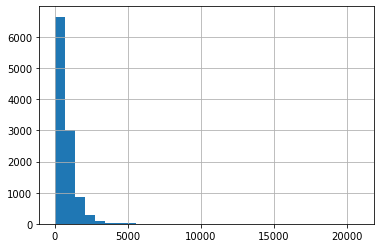

In [12]:
leb_bbdd.lens.hist(bins=30)

In [13]:
leb_bbdd.lens.max()

20849

In [14]:
leb_bbdd.sort_values('lens',ascending=False).head(10)

,Identifier,lens
196,254558.0,20849
2129,824779.0,15339
2717,1027073.0,13265
2640,1001522.0,12203
5374,1405512.0,8280
2871,1063597.0,8124
4543,1290365.0,7998
119,198638.0,7368
4433,1275598.0,6779
1076,514626.0,6472


In [15]:
taggs.head()

,Id,Ansiosa,Depresiva,Suicida,Temas_autoimagen,Temas_vinculares,Temas_sentido,Temas_emoción,Temas_violencia,Temas_desempeño,Temas_diversidad,estrategia_validación,estrategia_reflexionar,estrategia_recursos,estrategia_contención,estrategia_indagación,estrategia_educación,estrategia_derivación,recursos,gravedad,exito
0,1392562.0,0,1,1,0,0,0,0,1,1,0,1,0,1,1,1,0,0,Medio,Mucho,Medio
1,1396627.0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,Poco,Bastante,Medio
2,1405660.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,Poco,Bastante,Medio
3,1682719.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,Medio,Bastante,Medio
4,1746142.0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,Medio,Bastante,Poco


In [16]:
taggs.shape

(1000, 21)

In [17]:
len(taggs.Id.unique())

1000

Text preprocessing (tagged conversations)

In [18]:
%%time
taggs_texto = []

for ixd in range(taggs.shape[0]):
  ide = taggs.Id[ixd]
  df_texto = full5[full5.Identifier==ide].reset_index(drop=True)
  texto = []

  for ix in range(df_texto.shape[0]):
    if df_texto.person_type[ix]=='Client':
        mytext = df_texto.content2[ix].lower()
        mytext = mytext.replace(',',' , ')
        mytext = mytext.replace('.',' . ')
        asd = depen_parser(mytext)
        newtext = asd[asd.tag.isin(['NOUN','ADJ','VERB'])].lemma.tolist()
        texto.append(' '.join(newtext))

  texto= ' .'.join(texto)
  taggs_texto.append(texto)

taggs['texto'] = taggs_texto


C:\Users\usuario\anaconda3\envs\nlp1\lib\site-packages\stanza\models\common\beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


Wall time: 1h 1min 54s


In [19]:
taggs

,Id,Ansiosa,Depresiva,Suicida,Temas_autoimagen,Temas_vinculares,Temas_sentido,Temas_emoción,Temas_violencia,Temas_desempeño,Temas_diversidad,estrategia_validación,estrategia_reflexionar,estrategia_recursos,estrategia_contención,estrategia_indagación,estrategia_educación,estrategia_derivación,recursos,gravedad,exito,texto
0,1392562.0,0,1,1,0,0,0,0,1,1,0,1,0,1,1,1,0,0,Medio,Mucho,Medio,nn .perdón molestar sentir .pensar hacer malo ...
1,1396627.0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,Poco,Bastante,Medio,nn . .nn .querer dejar hacer daño persona quer...
2,1405660.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,Poco,Bastante,Medio,nn .hablar . .cortar hacer rato . .querer ver ...
3,1682719.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,Medio,Bastante,Medio,nn .sentir .querer vivir .hacer tiempo .día bu...
4,1746142.0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,Medio,Bastante,Poco,holar . .necesitar ayuda .eh tratar suicidarse...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2639723.0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,medio,mucho,medio,nn .deprimido sentir solo rato querer hacer da...
996,2695244.0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,medio,medio,mucho,nn .hablar tranquilo . .buen problema papás .d...
997,2799930.0,1,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,bastante,medio,mucho,nn conversión aplicación cerrar .cerrar .verda...
998,2896305.0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,bastante,bastante,medio,.amiga recomendar aplicación .necesitar ayuda...


In [20]:
taggs.sum()

Id                                                             1393604860.0
Ansiosa                                                                 278
Depresiva                                                               489
Suicida                                                                 384
Temas_autoimagen                                                        382
Temas_vinculares                                                        724
Temas_sentido                                                           149
Temas_emoción                                                           465
Temas_violencia                                                         213
Temas_desempeño                                                         321
Temas_diversidad                                                        165
estrategia_validación                                                   640
estrategia_reflexionar                                                  289
estrategia_r

### Random forest

#### For each topics, what is the performance of the classifier in the 1000 conversations, what are the optimized hyperparameters, and what are the predictor words

In [21]:
from nltk.corpus import stopwords
spn_stop = stopwords.words('spanish') + ['nn','xx']

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 2,lowercase = True, ngram_range = (1,2), use_idf = True, stop_words=spn_stop)

In [23]:
corpus = taggs.texto.tolist()
X = vectorizer.fit_transform(corpus)

#### Optimizing hyperparameters

In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = [100,125,150,175,200,250]

In [25]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features}

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_Model = RandomForestClassifier()

In [27]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

From here, the code for obtaining the predictor features in the same, so run it again changing the thematic family in "y = taggs.Temas_emoción"

In [28]:
y = taggs.Temas_emoción
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'max_features': [100, 125, 150, 175,
                                                         200, 250],
                                        'n_estimators': [100, 133, 166, 200,
                                                         233, 266, 300, 333,
                                                         366, 400]},
                   verbose=2)

In [30]:
param = rf_RandomGrid.best_params_

In [31]:
param

{'n_estimators': 366, 'max_features': 250}

In [32]:
param_vinculares = {'n_estimators': 333, 'max_features': 125}
param_autoimagen = {'n_estimators': 333, 'max_features': 250}
param_diversidad = {'n_estimators': 366, 'max_features': 250}
param_sentido = {'n_estimators': 233, 'max_features': 100}
param_desempeño = {'n_estimators': 100, 'max_features': 250}
param_violencia = {'n_estimators': 100, 'max_features': 250}
param_emocion = {'n_estimators': 166, 'max_features': 150}

In [33]:
rf = RandomForestClassifier(**param)
rf.fit(X_train,y_train)

RandomForestClassifier(max_features=250, n_estimators=366)

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(accuracy_score(y_test, rf.predict(X_test)))

confusion_matrix(y_test, rf.predict(X_test))


0.64


array([[75, 28],
       [44, 53]], dtype=int64)

In [35]:
feature_names = [i for i in range(X.shape[1])]
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

In [36]:
rf.predict(X_test)

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1], dtype=int64)

In [37]:
features = pd.DataFrame(forest_importances)
features = features.reset_index()
features['word']  = [vectorizer.get_feature_names()[x] for x in features.index]

C:\Users\usuario\anaconda3\envs\nlp1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
features.sort_values(0,ascending=False).head(40).word.tolist()

['llorar',
 'hacer',
 'crisis',
 'sentir',
 'dar',
 'tener',
 'pasar',
 'solo',
 'vida',
 'saber',
 'vez',
 'volver',
 'ansiedad',
 'miedo',
 'año',
 'aguantar',
 'familia',
 'ir',
 'necesitar',
 'hablar',
 'querer',
 'pecho',
 'cosa',
 'pensar',
 'mes',
 'gracias',
 'gana',
 'gustar',
 'buen',
 'cabeza',
 'creer',
 'casa',
 'controlar',
 'matar',
 'intentar',
 'pánico',
 'ayuda',
 'decir',
 'tiempo',
 'tratar']

In [39]:
temas_vinculares = ['decir', 'solo', 'hablar', 'hacer', 'cosa', 'tener', 'gustar', 'casa', 'pasar', 'amigo', 'buen', 'ver', 'creer', 'sentir', 'ayuda', 'querer', 'llegar', 'saber', 'persona', 'vez', 'mamá', 'amiga', 'sentir solo', 'seguir', 'padre', 'necesitar', 'gracias', 'miedo', 'terminar', 'intentar', 'papá', 'familia', 'tema', 'mejor', 'año', 'dejar', 'forma', 'necesitar ayuda', 'tiempo', 'salir']
temas_autoimagen = ['cuerpo', 'autoestima', 'feo', 'sentir', 'feliz', 'pensar', 'vez', 'año', 'dar', 'chile', 'cosa', 'querer', 'tener', 'inseguro', 'hacer', 'vida', 'saber', 'gana', 'odio', 'verdad', 'creer', 'negativo', 'gustar', 'decir', 'contar', 'ver', 'tiempo', 'asco', 'gente', 'gracias', 'buen', 'tonto', 'culpable', 'amigo', 'solo', 'dejar', 'lograr', 'intentar', 'tratar', 'hablar']
temas_diversidad = ['gay', 'homosexual', 'hombre', 'orientación', 'mujer', 'sexual', 'tran', 'aceptar', 'bisexual', 'lesbiano', 'clo', 'clo set', 'género', 'set', 'orientación sexual', 'trans', 'chico', 'chica', 'identidad', 'homofóbico', 'femenino', 'bi', 'hetero', 'niño', 'salir clo', 'sexo', 'transgénero', 'mujer hombre', 'gustar chica', 'polola', 'hormona', 'joven', 'hombre mujer', 'duda', 'gustar hombre', 'binario', 'definir', 'gustar mujer', 'osear', 'gracias ayuda']
temas_sentido    = ['vida', 'ayuda favor', 'suicidio', 'encontrar vida', 'morir', 'querer', 'favor', 'pensar', 'tener gana', 'llevar', 'tener sentir', 'intentar vez', 'suicidarse', 'peor', 'rendir', 'ayuda', 'desconocido', 'decir gustar', 'pensar suicidio', 'hacer', 'estudiar carrera', 'valer pena', 'decepcionar', 'dormir buen', 'intento', 'favor favor', 'querer seguir', 'daño querer', 'sentir sentir', 'tener', 'dema', 'vida hacer', 'sentir', 'vida tener', 'feliz', 'separado', 'inútil', 'gris', 'sociedad', 'motivación']
temas_desempeño  = ['estudiar', 'trabajo', 'carrera', 'universidad', 'sentir', 'papá', 'tiempo', 'vez', 'tener', 'triste sentir', 'lograr', 'mamá', 'capaz', 'año', 'casa', 'odio', 'vivir', 'solo', 'hacer', 'gustar', 'gana', 'mente', 'pasar', 'punto', 'costar', 'medio', 'llorar', 'buen', 'cosa', 'esperar', 'peor', 'decepcionar', 'mejorar', 'estresar', 'problema', 'tener trabajo', 'pensar', 'saber', 'igual', 'cambio']
temas_violencia  = ['dejar', 'pegar', 'sufrir', 'violencia', 'abuso', 'decir', 'hija', 'bullying', 'casa', 'golpear', 'molestar', 'carabinero', 'tia', 'bebé', 'ir tener', 'año', 'ex', 'papá', 'sufrir bullying', 'padre', 'querer salir', 'año sufrir', 'tio', 'bulling', 'abusado', 'cosa decir', 'verdad hablar', 'insultar', 'salir', 'sufrir depresión', 'niña', 'hermano', 'amenazar', 'crecer', 'detalle', 'colegio', 'vivir', 'dar', 'robar', 'buen']    
temas_emocion    = ['crisis', 'llorar', 'tener', 'sentir', 'hacer', 'pasar', 'dar', 'vez', 'solo', 'ansiedad', 'miedo', 'año', 'mes', 'volver', 'aguantar', 'cosa', 'necesitar', 'hablar', 'familia','saber', 'pánico', 'tiempo', 'querer', 'horrible', 'día', 'pecho', 'matar', 'vida', 'casa', 'pastilla', 'ir', 'llegar', 'dia', 'pensar', 'angustia', 'gustar', 'creer', 'tener crisis', 'decir', 'rato'] 

## Time evolution of thematic families

Removing conversations if they have 10 or less messages. 

In [40]:
conver_size = full5.groupby(['Identifier']).content.size().reset_index()
remove_id = conver_size[conver_size.content<=10].Identifier

In [41]:
full5 = full5[~full5.Identifier.isin(remove_id)]

In [42]:
full5.shape

(635806, 12)

Creating "year-month" variable, and counting the number of conversations by year-month

In [43]:
full5['yearm'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m') for x in full5.message_created_at]
full5 = full5[full5.yearm.astype(str)!='2021-01'] 
converdate = full5.groupby(['yearm']).Identifier.nunique().reset_index()
converdate = converdate.rename(columns={'Identifier':'total'})

<AxesSubplot:>

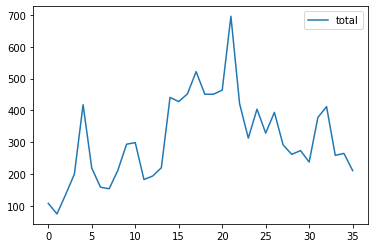

In [44]:
converdate.plot()

In [45]:
converdate

,yearm,total
0,2018-01,108
1,2018-02,75
2,2018-03,136
3,2018-04,200
4,2018-05,418
5,2018-06,219
6,2018-07,159
7,2018-08,154
8,2018-09,212
9,2018-10,294


### Applying dictionarys to the whole corpus. 

In [46]:
short_autoimagen = ['cuerpo', 'autoestima', 'feo','fea', 'inseguro','insegura','odio', 'negativo', 'negativa','asco','arreglarme','agraciada','agraciado','atractivo','atractiva','rechazo','sirvo','sobro','comer','espejo', 'anormal','gorda','gordo','bonito','obesidad','obeso','obesa','autoimagen','corporal'] 
short_violencia = ['violaron','violación','violó','bullying', 'bulling', 'bullyng','abuso', 'abusa','abusó','abusaron', 'violencia', 'maltrato', 'acoso','acosa','acosan','agresión','pegar','pegan','pegaban', 'pegó','golpes','golpea','golpean','golpeaban','gritos','humilla','humillan']    
short_diversidad = ['gay', 'homosexual',  'orientación',  'trans', 'bisexual', 'lesbiana', 'closet',  'género',  'homofóbico', 'homofóbica', 'homofóbicos', 'hetero', 'transgénero', 'binario','hermafrodita','intersexual','fluido','bigénero','agénero','demisexual','pansexual']
short_sentido = ['miedos', 'fingir','rendí','rindo', 'rendirse', 'medioambiente', 'desesperanza', 'ecológico','ecológica' ,  'decepcionado', 'decepcionada','desmotivado' , 'desmotivada','esperanzado','esperanzada','desesperanzado','desesperanzada','motivación','motive' ] 
short_vinculares = [  'amigo', 'amigos', 'amiga', 'amigas', 'sola','padre', 'papá', 'familia','familiar', 'papás','padres', 'pareja','pololo','polola', 'discutir','discutí','discutimos','terminó', 'acabó','amigues', 'amigxs', 'hermanos','mamá', 'madre', 'terminamos',  'tóxica',  'casa']
short_emocion = ['crisis', 'llorar', 'llanto', 'ansiedad',  'pánico', 'pecho',  'angustia', 'respiración', 'respirar', 'sudando','temblor', 'tiembla', 'tiemblan', 'pulso','miedos']
short_desempeño = ['carrera', 'estudio', 'sueldo', 'universidad', 'notas' , 'psu' , 'insuficiente', 'trabajo' , 'trabajar', 'plata' , 'dinero', 'rendimiento', 'insuficientes', 'esfuerzo', 'prueba', 'esforzarme', 'preu' ]


In [47]:
%%time
autoimagen = []
violencia = []
diversidad = []
desempeño = []
sentido = []
vinculares = []
emocion = []
all_id = full5.Identifier.tolist()
all_id = list(set(all_id))
for idd in all_id:
  df_texto = full5[full5.Identifier==idd].reset_index(drop=True)
  texto = []
  for ix in range(df_texto.shape[0]):
    if df_texto.person_type[ix]=='Client':
        mytext = df_texto.content[ix]
        if isinstance(mytext,str):
          mytext = mytext.lower()
          mytext = mytext.replace('clo set','closet')
          mytext = mytext.replace(',',' , ')
          mytext = mytext.replace('.',' . ')
          mytext = mytext.replace('(',' ( ')
          mytext = mytext.replace(')',' ) ')
          mytext = re.sub('\W+',' ', mytext)
          texto.append(mytext)
  texto = ' '.join(texto)      
  aa = len(list(set(texto.split()) & set(short_autoimagen)) ) 
  vv = len(list(set(texto.split()) & set(short_violencia)) )
  dd = len(list(set(texto.split()) & set(short_diversidad)) )
  de = len(list(set(texto.split()) & set(short_desempeño)) )
  ss = len(list(set(texto.split()) & set(short_sentido)) )
  vn = len(list(set(texto.split()) & set(short_vinculares)) )
  ee = len(list(set(texto.split()) & set(short_emocion)) )
  
  autoimagen.append(aa)
  violencia.append(vv)
  diversidad.append(dd)
  desempeño.append(de)
  sentido.append(ss)
  vinculares.append(vn)
  emocion.append(ee)

Wall time: 29.6 s


In [48]:
auto_textos = pd.DataFrame({'Id': all_id, 'autoimagen': autoimagen, 'violencia':violencia, 'diversidad':diversidad,'desempeño':desempeño,'sentido':sentido,'vinculares':vinculares, 'emocion':emocion })
auto_textos.autoimagen = [1 if x>0 else 0 for x in auto_textos.autoimagen]
auto_textos.violencia = [1 if x>0 else 0 for x in auto_textos.violencia]
auto_textos.diversidad = [1 if x>0 else 0 for x in auto_textos.diversidad]
auto_textos.desempeño = [1 if x>0 else 0 for x in auto_textos.desempeño]
auto_textos.sentido = [1 if x>0 else 0 for x in auto_textos.sentido]
auto_textos.vinculares = [1 if x>0 else 0 for x in auto_textos.vinculares]
auto_textos.emocion = [1 if x>0 else 0 for x in auto_textos.emocion]

Proportion of each theme in the 1000 tagged conversations:

Temas_autoimagen                                                        382  

Temas_vinculares                                                        724

Temas_sentido                                                           149

Temas_emoción                                                           465

Temas_violencia                                                         213

Temas_desempeño                                                         321

Temas_diversidad                                                        165

In [49]:
print('Autoimagen: ' ,round(auto_textos[auto_textos.autoimagen>0].shape[0]/auto_textos.shape[0],2)) # 33
print('Violencia: ' ,round(auto_textos[auto_textos.violencia>0].shape[0]/auto_textos.shape[0],2)) # 15
print('Diversidad: ' ,round(auto_textos[auto_textos.diversidad>0].shape[0]/auto_textos.shape[0],2)) # 16
print('Desempeño: ' ,round(auto_textos[auto_textos.desempeño>0].shape[0]/auto_textos.shape[0],2)) # 32
print('Sentido: ' ,round(auto_textos[auto_textos.sentido>0].shape[0]/auto_textos.shape[0],2)) # 6
print('Vinculares: ' ,round(auto_textos[auto_textos.vinculares>0].shape[0]/auto_textos.shape[0],2 )) # 78
print('Emoción: ' ,round(auto_textos[auto_textos.emocion>0].shape[0]/auto_textos.shape[0],2))  # 35

Autoimagen:  0.33
Violencia:  0.15
Diversidad:  0.16
Desempeño:  0.32
Sentido:  0.06
Vinculares:  0.78
Emoción:  0.35


In [50]:
auto_textos = auto_textos.merge(full5[['yearm','Identifier']].drop_duplicates(), left_on='Id', right_on='Identifier')

In [51]:
auto_textos.head()

,Id,autoimagen,violencia,diversidad,desempeño,sentido,vinculares,emocion,yearm,Identifier
0,589825.0,1,0,1,0,0,1,0,2018-07,589825.0
1,1703949.0,0,0,0,1,0,1,0,2020-01,1703949.0
2,1277966.0,0,0,0,0,0,0,0,2019-06,1277966.0
3,2293776.0,1,0,0,1,0,1,1,2020-06,2293776.0
4,1703962.0,0,0,0,1,0,1,1,2020-01,1703962.0


In [52]:
auto_textos.shape

(11228, 10)

### Comparison between dictionary and manual tagging (dictionary evaluation)

In [53]:
taggs.head()

,Id,Ansiosa,Depresiva,Suicida,Temas_autoimagen,Temas_vinculares,Temas_sentido,Temas_emoción,Temas_violencia,Temas_desempeño,Temas_diversidad,estrategia_validación,estrategia_reflexionar,estrategia_recursos,estrategia_contención,estrategia_indagación,estrategia_educación,estrategia_derivación,recursos,gravedad,exito,texto
0,1392562.0,0,1,1,0,0,0,0,1,1,0,1,0,1,1,1,0,0,Medio,Mucho,Medio,nn .perdón molestar sentir .pensar hacer malo ...
1,1396627.0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,Poco,Bastante,Medio,nn . .nn .querer dejar hacer daño persona quer...
2,1405660.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,Poco,Bastante,Medio,nn .hablar . .cortar hacer rato . .querer ver ...
3,1682719.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,Medio,Bastante,Medio,nn .sentir .querer vivir .hacer tiempo .día bu...
4,1746142.0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,Medio,Bastante,Poco,holar . .necesitar ayuda .eh tratar suicidarse...


In [54]:
taggs_dic = auto_textos[auto_textos.Id.isin(taggs.Id)]

In [55]:
taggs_dic.shape

(1027, 10)

In [56]:
len(taggs_dic.Id.unique())

999

### Emoción

In [57]:
emocion = taggs[['Temas_emoción','Id']].merge(taggs_dic[['emocion','Id']])

In [58]:
TP = emocion[(emocion.Temas_emoción==1) & (emocion.emocion==1)].shape[0]
FP = emocion[(emocion.Temas_emoción==0) & (emocion.emocion==1)].shape[0]
TN = emocion[(emocion.Temas_emoción==0) & (emocion.emocion==0)].shape[0]
FN = emocion[(emocion.Temas_emoción==1) & (emocion.emocion==0)].shape[0]
accuracy = (TP+TN) / (TP + FP + TN + FN )
precision = TP / (TP + FP)
recall  = TP / (TP + FN)
print('accuracy: ',accuracy) 
print('precision: ',precision) 
print('recall: ',recall) 

accuracy:  0.6572541382667965
precision:  0.6535626535626535
recall:  0.5576519916142557


### Vinculares

In [59]:
vinculares = taggs[['Temas_vinculares','Id']].merge(taggs_dic[['vinculares','Id']])

In [60]:
TP = vinculares[(vinculares.Temas_vinculares==1) & (vinculares.vinculares==1)].shape[0]
FP = vinculares[(vinculares.Temas_vinculares==0) & (vinculares.vinculares==1)].shape[0]
TN = vinculares[(vinculares.Temas_vinculares==0) & (vinculares.vinculares==0)].shape[0]
FN = vinculares[(vinculares.Temas_vinculares==1) & (vinculares.vinculares==0)].shape[0]

accuracy = (TP+TN) / (TP + FP + TN + FN )
precision = TP / (TP + FP)
recall  = TP / (TP + FN)
print('accuracy: ',accuracy) 
print('precision: ',precision) 
print('recall: ',recall) 

accuracy:  0.7955209347614411
precision:  0.8302583025830258
recall:  0.9036144578313253


### Violencia

In [61]:
violencia = taggs[['Temas_violencia','Id']].merge(taggs_dic[['violencia','Id']])

In [62]:
TP = violencia[(violencia.Temas_violencia==1) & (violencia.violencia==1)].shape[0]
FP = violencia[(violencia.Temas_violencia==0) & (violencia.violencia==1)].shape[0]
TN = violencia[(violencia.Temas_violencia==0) & (violencia.violencia==0)].shape[0]
FN = violencia[(violencia.Temas_violencia==1) & (violencia.violencia==0)].shape[0]

accuracy = (TP+TN) / (TP + FP + TN + FN )
precision = TP / (TP + FP)
recall  = TP / (TP + FN)
print('accuracy: ',accuracy) 
print('precision: ',precision) 
print('recall: ',recall) 

accuracy:  0.8646543330087634
precision:  0.7651006711409396
recall:  0.5229357798165137


### Diversidad

In [63]:
diversidad = taggs[['Temas_diversidad','Id']].merge(taggs_dic[['diversidad','Id']])

In [64]:
TP = diversidad[(diversidad.Temas_diversidad==1) & (diversidad.diversidad==1)].shape[0]
FP = diversidad[(diversidad.Temas_diversidad==0) & (diversidad.diversidad==1)].shape[0]
TN = diversidad[(diversidad.Temas_diversidad==0) & (diversidad.diversidad==0)].shape[0]
FN = diversidad[(diversidad.Temas_diversidad==1) & (diversidad.diversidad==0)].shape[0]

accuracy = (TP+TN) / (TP + FP + TN + FN )
precision = TP / (TP + FP)
recall  = TP / (TP + FN)
print('accuracy: ',accuracy) 
print('precision: ',precision) 
print('recall: ',recall) 

accuracy:  0.9308666017526777
precision:  0.8223684210526315
recall:  0.7396449704142012


### Desempeño

In [65]:
desempeño = taggs[['Temas_desempeño','Id']].merge(taggs_dic[['desempeño','Id']])

In [66]:
TP = desempeño[(desempeño.Temas_desempeño==1) & (desempeño.desempeño==1)].shape[0]
FP = desempeño[(desempeño.Temas_desempeño==0) & (desempeño.desempeño==1)].shape[0]
TN = desempeño[(desempeño.Temas_desempeño==0) & (desempeño.desempeño==0)].shape[0]
FN = desempeño[(desempeño.Temas_desempeño==1) & (desempeño.desempeño==0)].shape[0]

accuracy = (TP+TN) / (TP + FP + TN + FN )
precision = TP / (TP + FP)
recall  = TP / (TP + FN)
print('accuracy: ',accuracy) 
print('precision: ',precision) 
print('recall: ',recall) 

accuracy:  0.7108081791626095
precision:  0.543010752688172
recall:  0.6139817629179332


### Autoimagen

In [67]:
autoimagen = taggs[['Temas_autoimagen','Id']].merge(taggs_dic[['autoimagen','Id']])

In [68]:
TP = autoimagen[(autoimagen.Temas_autoimagen==1) & (autoimagen.autoimagen==1)].shape[0]
FP = autoimagen[(autoimagen.Temas_autoimagen==0) & (autoimagen.autoimagen==1)].shape[0]
TN = autoimagen[(autoimagen.Temas_autoimagen==0) & (autoimagen.autoimagen==0)].shape[0]
FN = autoimagen[(autoimagen.Temas_autoimagen==1) & (autoimagen.autoimagen==0)].shape[0]

accuracy = (TP+TN) / (TP + FP + TN + FN )
precision = TP / (TP + FP)
recall  = TP / (TP + FN)
print('accuracy: ',accuracy) 
print('precision: ',precision) 
print('recall: ',recall) 

accuracy:  0.7273612463485881
precision:  0.6569767441860465
recall:  0.5824742268041238


### Sentido

In [69]:
sentido = taggs[['Temas_sentido','Id']].merge(taggs_dic[['sentido','Id']])

In [70]:
TP = sentido[(sentido.Temas_sentido==1) & (sentido.sentido==1)].shape[0]
FP = sentido[(sentido.Temas_sentido==0) & (sentido.sentido==1)].shape[0]
TN = sentido[(sentido.Temas_sentido==0) & (sentido.sentido==0)].shape[0]
FN = sentido[(sentido.Temas_sentido==1) & (sentido.sentido==0)].shape[0]

accuracy = (TP+TN) / (TP + FP + TN + FN )
precision = TP / (TP + FP)
recall  = TP / (TP + FN)
print('accuracy: ',accuracy) 
print('precision: ',precision) 
print('recall: ',recall) 

accuracy:  0.8364167478091529
precision:  0.3870967741935484
recall:  0.15584415584415584


### Time series for each thematic family

In [71]:
temas_tiempo = auto_textos.groupby(['yearm']).sum().reset_index().drop(['Id','Identifier'],axis=1)
temas_tiempo = temas_tiempo.merge(converdate, on='yearm')

In [72]:
temas_tiempo['autoimagenN'] = temas_tiempo.autoimagen/temas_tiempo.total
temas_tiempo['violenciaN'] = temas_tiempo.violencia/temas_tiempo.total
temas_tiempo['diversidadN'] = temas_tiempo.diversidad/temas_tiempo.total
temas_tiempo['desempeñoN'] = temas_tiempo.desempeño/temas_tiempo.total
temas_tiempo['sentidoN'] = temas_tiempo.sentido/temas_tiempo.total
temas_tiempo['vincularesN'] = temas_tiempo.vinculares/temas_tiempo.total

In [73]:
temas_tiempo['emocionN'] = temas_tiempo.emocion/temas_tiempo.total

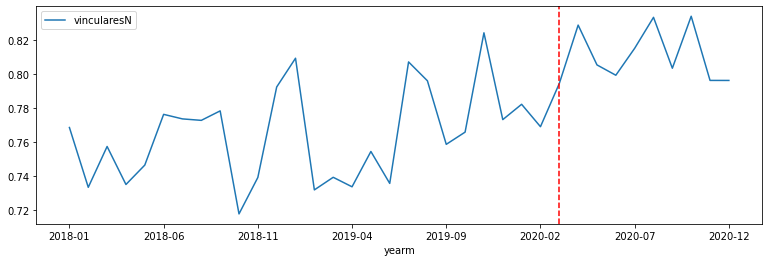

In [74]:
ax = temas_tiempo.plot(x='yearm',y='vincularesN',figsize=(13,4))

#ax.axvline(21, color="red", linestyle="--")
ax.axvline(26, color="red", linestyle="--")
plt.savefig("vinculares.svg")

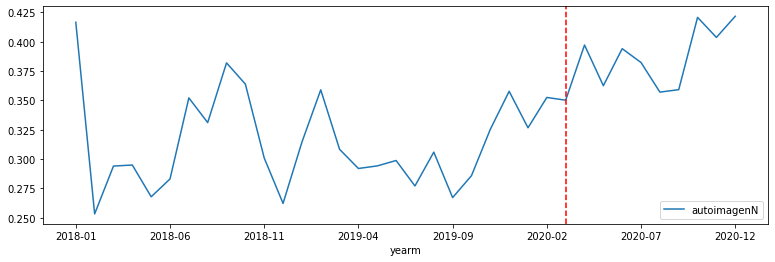

In [75]:
ax = temas_tiempo.plot(x='yearm',y='autoimagenN',figsize=(13,4))


ax.axvline(26, color="red", linestyle="--")
plt.savefig("autoimagen.svg")

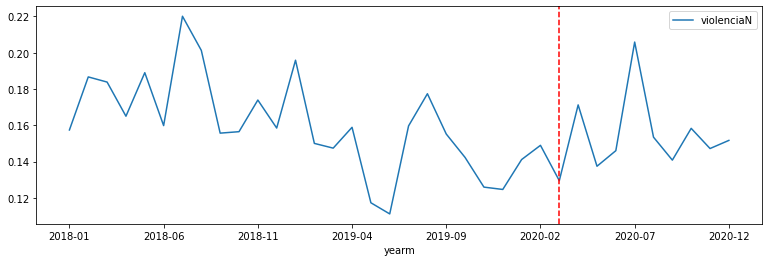

In [76]:
ax = temas_tiempo.plot(x='yearm',y='violenciaN',figsize=(13,4))


ax.axvline(26, color="red", linestyle="--")

plt.savefig("violencia.svg")

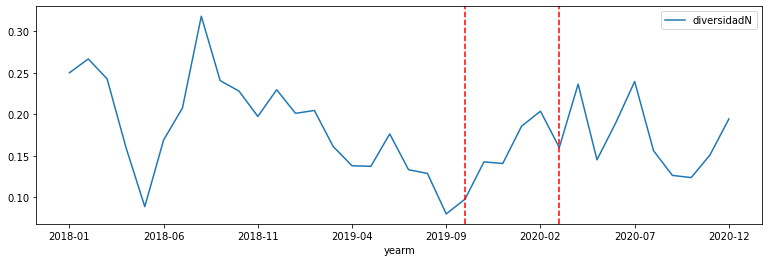

In [77]:
ax = temas_tiempo.plot(x='yearm',y='diversidadN',figsize=(13,4))

ax.axvline(21, color="red", linestyle="--")
ax.axvline(26, color="red", linestyle="--")

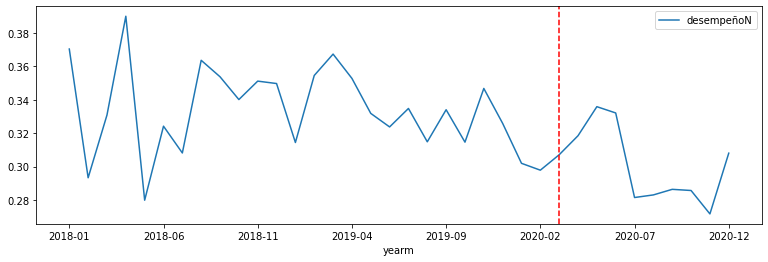

In [78]:
ax = temas_tiempo.plot(x='yearm',y='desempeñoN',figsize=(13,4))


ax.axvline(26, color="red", linestyle="--")

plt.savefig("desempeño.svg")

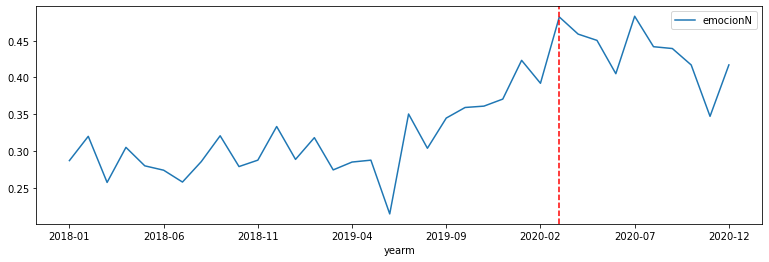

In [79]:
ax = temas_tiempo.plot(x='yearm',y='emocionN',figsize=(13,4))


ax.axvline(26, color="red", linestyle="--")
plt.savefig("emcion.svg")

### Logits models

In [80]:
taggs.shape
len(taggs.Id.unique())

1000

In [81]:
taggs_date = taggs.copy()

In [82]:
taggs_date = taggs_date.merge(full5[['yearm','Identifier']].drop_duplicates(), how='left',left_on='Id', right_on='Identifier')

In [83]:
taggs_date[0:50]

,Id,Ansiosa,Depresiva,Suicida,Temas_autoimagen,Temas_vinculares,Temas_sentido,Temas_emoción,Temas_violencia,Temas_desempeño,Temas_diversidad,estrategia_validación,estrategia_reflexionar,estrategia_recursos,estrategia_contención,estrategia_indagación,estrategia_educación,estrategia_derivación,recursos,gravedad,exito,texto,yearm,Identifier
0,1392562.0,0,1,1,0,0,0,0,1,1,0,1,0,1,1,1,0,0,Medio,Mucho,Medio,nn .perdón molestar sentir .pensar hacer malo ...,2019-08,1392562.0
1,1396627.0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,Poco,Bastante,Medio,nn . .nn .querer dejar hacer daño persona quer...,2019-08,1396627.0
2,1405660.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,Poco,Bastante,Medio,nn .hablar . .cortar hacer rato . .querer ver ...,2019-08,1405660.0
3,1682719.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,Medio,Bastante,Medio,nn .sentir .querer vivir .hacer tiempo .día bu...,2020-01,1682719.0
4,1746142.0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,Medio,Bastante,Poco,holar . .necesitar ayuda .eh tratar suicidarse...,2020-02,1746142.0
5,1754193.0,1,1,1,0,1,0,1,0,0,0,1,0,1,1,0,0,0,Medio,Bastante,Bastante,nn .necesitar ayuda c .favor .sentir .hablar v...,2020-02,1754193.0
6,2343695.0,1,0,1,1,1,0,1,1,0,0,1,0,0,1,1,0,0,Medio,Mucho,Medio,vez escribir .necesitar ayuda .tener pensamien...,2020-07,2343695.0
7,2662419.0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,Medio,Medio,Medio,nn . .ayudar .contar .familia apoyar simple ra...,2020-09,2662419.0
8,2761544.0,1,1,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,Medio,Bastante,Bastante,nn .querer desahogar .meter ver nota ver rojo ...,2020-10,2761544.0
9,2798046.0,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,1,0,Bastante,Mucho,Medio,ir psiquiatra primero vez diagnóstico ansiedad...,2020-10,2798046.0


In [84]:
pre_pandemic= ['2018-01', '2018-02', '2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01', '2020-02']
post_pandemic = ['2020-03','2020-04','2020-05','2020-06','2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']

taggs_date['pandemic'] = [1 if x in post_pandemic else 0 for x in taggs_date.yearm]

In [85]:
taggs_date.shape

(1028, 25)

In [86]:
taggs_date.drop(['yearm'],axis=1,inplace=True)

In [87]:
taggs_date = taggs_date.drop_duplicates()

In [88]:
taggs_date.shape

(1000, 24)

In [89]:
taggs_date.sample(10)

,Id,Ansiosa,Depresiva,Suicida,Temas_autoimagen,Temas_vinculares,Temas_sentido,Temas_emoción,Temas_violencia,Temas_desempeño,Temas_diversidad,estrategia_validación,estrategia_reflexionar,estrategia_recursos,estrategia_contención,estrategia_indagación,estrategia_educación,estrategia_derivación,recursos,gravedad,exito,texto,Identifier,pandemic
307,2080088.0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,1,0,0,medio,bastante,medio,necesitar ayuda víctima violencia intrafamilia...,2080088.0,1
807,1750814.0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,nada,poco,nada,nn .querer conversar .mismo .sentir .sentir mo...,1750814.0,0
743,1636950.0,0,1,1,1,1,1,0,0,1,0,1,0,1,1,1,0,0,poco,medio,medio,buen .considerar idea quitar vida .venir carga...,1636950.0,0
50,330517.0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,medio,medio,bastante,.nn .nuevo soler llamar nn cómodo mencionar d...,330517.0,0
678,737219.0,0,0,0,1,1,0,0,0,1,1,1,1,0,1,1,1,0,poco,poco,bastante,nn .tener pregunta duda tener .vez gustar chic...,737219.0,0
522,1154994.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,poco,medio,medio,nn .nn .tener creer hablar joven .tener pensam...,1154994.0,0
954,1216179.0,1,1,1,0,1,0,1,1,0,0,1,0,1,1,1,0,0,medio,bastante,bastante,nn .emm buscar instagram llegar pagina .leer c...,1216179.0,0
386,1262402.0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,1,1,0,bastante,poco,bastante,.necesitar ayuda .verdad amigo sentir hacer c...,1262402.0,0
707,1756884.0,0,1,0,0,1,0,0,1,1,0,1,0,1,1,1,1,0,poco,medio,medio,nn .gustar dejar deprimir positivo .vivir solo...,1756884.0,0
758,2148289.0,0,1,1,1,0,1,0,0,0,1,1,0,1,1,0,0,0,medio,bastante,medio,nn .sentir culpa gustar chico sentir culpa pre...,2148289.0,1


In [90]:
taggs_date.shape

(1000, 24)

In [91]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant

In [92]:
taggs_date["estrategia_validación"] = taggs_date["estrategia_validación"].astype("category")
taggs_date["estrategia_reflexionar"] = taggs_date["estrategia_reflexionar"].astype("category")
taggs_date["estrategia_recursos"] = taggs_date["estrategia_recursos"].astype("category")
taggs_date["estrategia_contención"] = taggs_date["estrategia_contención"].astype("category")
taggs_date["estrategia_indagación"] = taggs_date["estrategia_indagación"].astype("category")
taggs_date["estrategia_educación"] = taggs_date["estrategia_educación"].astype("category")
taggs_date["estrategia_derivación"] = taggs_date["estrategia_derivación"].astype("category")
taggs_date["Temas_autoimagen"] = taggs_date["Temas_autoimagen"].astype("category")
taggs_date["Temas_vinculares"] = taggs_date["Temas_vinculares"].astype("category")
taggs_date["Temas_sentido"] = taggs_date["Temas_sentido"].astype("category")
taggs_date["Temas_emoción"] = taggs_date["Temas_emoción"].astype("category")
taggs_date["Temas_violencia"] = taggs_date["Temas_violencia"].astype("category")
taggs_date["Temas_desempeño"] = taggs_date["Temas_desempeño"].astype("category")
taggs_date["Temas_diversidad"] = taggs_date["Temas_diversidad"].astype("category")
taggs_date["pandemic"] = taggs_date["pandemic"].astype("category")


feature_cols = ['Temas_autoimagen','Temas_vinculares','Temas_emoción','Temas_violencia','Temas_desempeño','Temas_diversidad','estrategia_validación', 'estrategia_reflexionar', 'estrategia_recursos', 'estrategia_contención','estrategia_indagación','estrategia_educación','estrategia_derivación','pandemic']
X = taggs_date[feature_cols] # Features
X = pd.get_dummies(X, columns=['Temas_autoimagen','Temas_vinculares','Temas_emoción','Temas_violencia','Temas_desempeño','Temas_diversidad','estrategia_validación', 'estrategia_reflexionar', 'estrategia_recursos','estrategia_contención','estrategia_indagación','estrategia_educación','estrategia_derivación','pandemic'], drop_first = True)

X = add_constant(X)

#### Suicidal behavior

In [93]:
y_suicida = taggs_date.Suicida
res1 = smf.logit(formula='y_suicida ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1', data=X).fit()
res2 = smf.logit(formula='y_suicida ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1 + pandemic_1', data=X).fit()

Optimization terminated successfully.
         Current function value: 0.606465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602954
         Iterations 5


In [94]:
stargazer = Stargazer([res1])
stargazer

In [95]:
stargazer = Stargazer([res2])
stargazer
#print(stargazer.render_latex())

In [96]:
#logit_model=sm.Logit(y_suicida,X.drop(['pandemic_1'],axis=1))
logit_model=sm.Logit(y_suicida,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.602954
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Suicida   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           14
Date:                Wed, 19 Apr 2023   Pseudo R-squ.:                 0.09465
Time:                        19:39:29   Log-Likelihood:                -602.95
converged:                       True   LL-Null:                       -665.99
Covariance Type:            nonrobust   LLR p-value:                 4.049e-20
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.6241      0.205     -3.043      0.002      -1.026

#### Depressive symptomatology

In [97]:
y_depre = taggs_date.Depresiva
#logit_model=sm.Logit(y_depre,X.drop(['pandemic_1'],axis=1))
logit_model=sm.Logit(y_depre,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.592728
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Depresiva   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           14
Date:                Wed, 19 Apr 2023   Pseudo R-squ.:                  0.1446
Time:                        19:39:29   Log-Likelihood:                -592.73
converged:                       True   LL-Null:                       -692.91
Covariance Type:            nonrobust   LLR p-value:                 4.651e-35
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.3330      0.216     -6.179      0.000      -1.756

In [98]:
res1 = smf.logit(formula='y_depre ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1', data=X).fit()
res2 = smf.logit(formula='y_depre ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1 + pandemic_1', data=X).fit()


Optimization terminated successfully.
         Current function value: 0.593045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592728
         Iterations 5


In [99]:
stargazer = Stargazer([res1])
stargazer

In [100]:
stargazer = Stargazer([res2])
stargazer
#print(stargazer.render_latex())

#### Anxious symptomatology

In [101]:
y_ansiosa = taggs_date.Ansiosa
#logit_model=sm.Logit(y_ansiosa,X.drop(['pandemic_1'],axis=1))
logit_model=sm.Logit(y_ansiosa,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.529854
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Ansiosa   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           14
Date:                Wed, 19 Apr 2023   Pseudo R-squ.:                  0.1035
Time:                        19:39:29   Log-Likelihood:                -529.85
converged:                       True   LL-Null:                       -591.05
Covariance Type:            nonrobust   LLR p-value:                 2.128e-19
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.2958      0.263     -8.718      0.000      -2.812

In [102]:
res1 = smf.logit(formula='y_ansiosa ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1', data=X).fit()
res2 = smf.logit(formula='y_ansiosa ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1 + pandemic_1', data=X).fit()


Optimization terminated successfully.
         Current function value: 0.530345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529854
         Iterations 6


In [103]:
stargazer = Stargazer([res1])
stargazer

In [104]:
stargazer = Stargazer([res2])
stargazer
#print(stargazer.render_latex())

In [105]:
res_suicida = smf.logit(formula='y_suicida ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1', data=X).fit()
res_depre =     smf.logit(formula='y_depre ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1', data=X).fit()
res_ansiosa = smf.logit(formula='y_ansiosa ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1', data=X).fit()
stargazer = Stargazer([res_suicida,res_depre,res_ansiosa])

Optimization terminated successfully.
         Current function value: 0.606465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530345
         Iterations 6


In [106]:
stargazer
#print(stargazer.render_latex()) # suicida, depresiva, ansiosa

In [107]:
res_suicida = smf.logit(formula='y_suicida ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1 + pandemic_1', data=X).fit()
res_depre =     smf.logit(formula='y_depre ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1 + pandemic_1', data=X).fit()
res_ansiosa = smf.logit(formula='y_ansiosa ~  Temas_autoimagen_1 + Temas_vinculares_1 + Temas_emoción_1 + Temas_violencia_1 + Temas_desempeño_1 + Temas_diversidad_1 + estrategia_validación_1 + estrategia_reflexionar_1 + estrategia_recursos_1 + estrategia_contención_1 + estrategia_indagación_1 + estrategia_educación_1 + estrategia_derivación_1 + pandemic_1', data=X).fit()
stargazer = Stargazer([res_suicida,res_depre,res_ansiosa])

Optimization terminated successfully.
         Current function value: 0.602954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529854
         Iterations 6


In [108]:
print(stargazer.render_latex())


\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 Intercept & -0.624$^{***}$ & -1.333$^{***}$ & -2.296$^{***}$ \\
  & (0.205) & (0.216) & (0.263) \\
 Temas_autoimagen_1 & 0.443$^{***}$ & 0.491$^{***}$ & -0.199$^{}$ \\
  & (0.155) & (0.154) & (0.169) \\
 Temas_desempeño_1 & -0.281$^{*}$ & 0.499$^{***}$ & 0.068$^{}$ \\
  & (0.160) & (0.159) & (0.170) \\
 Temas_diversidad_1 & -0.535$^{***}$ & -0.485$^{**}$ & -0.021$^{}$ \\
  & (0.203) & (0.198) & (0.212) \\
 Temas_emoción_1 & 0.630$^{***}$ & 0.813$^{***}$ & 1.063$^{***}$ \\
  & (0.149) & (0.151) & (0.165) \\
 Temas_vinculares_1 & -0.359$^{**}$ & 0.139$^{}$ & -0.190$^{}$ \\
  & (0.171) & (0.171) & (0.187) \\
 Temas_violencia_1 & 0.327$^{*}$ & 0.418$^{**}$ & -0.164$^{}$ \\
  & (0.173) & (0.179) & (0.189) \\
 estrategia_contención_1 & 0.569$^{***}$ & 0.242$^{}$ & -0.138$^{}$ \\
  & (0.187) & (0.178) & (0.204) \\
 estrategia_derivació